In [1]:
# import libraries
import json
import math
import os
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization


from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.applications import VGG19
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator,image,img_to_array,load_img
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam,RMSprop,SGD
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
input_dir = "../input/pneumonia-separated/sep/"
train_dir = input_dir +"train_sep/"
test_dir = input_dir +"test_sep/"


In [3]:
print(os.listdir(train_dir))
print(os.listdir(test_dir ))

['bacteria', 'virus']
['bacteria', 'virus']


In [4]:
import timeit

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                                       zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
    
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=train_dir, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary')

    test_gen = test_val_datagen.flow_from_directory(
    directory=test_dir, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary')
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/bacteria/', '/virus/']:
        for img in (os.listdir(test_dir + cond)):
            img = plt.imread(test_dir+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/bacteria/':
                label = 0
            elif cond=='/virus/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [6]:
img_dims = 150
batch_size = 20
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 3875 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 3875 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [8]:
from keras.optimizers import Adam, RMSprop, Adamax

In [9]:
# Create inception Model with Keras library

#adamax = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax", **kwargs)

# Create inception Model with Keras library
incep =  InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adamax(lr=lr),
        metrics=['acc']
    )
    return model

model = build_model(incep ,lr = 1e-4)
model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
batch_normalization_95 (Batc (None, 3, 3, 2048)        8192      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 23,860,977
Trainable params: 23,822,449
N

In [10]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=7)

# Fit Model
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=250,
    epochs=25,
    validation_data=test_generator,
    validation_steps=10,
    callbacks=[early_stopping_monitor]
)

Epoch 1/25
250/250 [==============================] - 159s 637ms/step - loss: 0.6690 - acc: 0.6403 - val_loss: 0.4940 - val_acc: 0.8000
Epoch 2/25
250/250 [==============================] - 115s 459ms/step - loss: 0.5973 - acc: 0.7030 - val_loss: 0.5826 - val_acc: 0.8368
Epoch 3/25
250/250 [==============================] - 118s 474ms/step - loss: 0.5903 - acc: 0.7068 - val_loss: 0.3362 - val_acc: 0.8350
Epoch 4/25
250/250 [==============================] - 118s 471ms/step - loss: 0.5648 - acc: 0.7237 - val_loss: 0.3139 - val_acc: 0.9053
Epoch 5/25
250/250 [==============================] - 118s 473ms/step - loss: 0.5725 - acc: 0.7203 - val_loss: 0.3200 - val_acc: 0.9100
Epoch 6/25
250/250 [==============================] - 118s 472ms/step - loss: 0.5373 - acc: 0.7371 - val_loss: 0.3422 - val_acc: 0.8737
Epoch 7/25
250/250 [==============================] - 118s 474ms/step - loss: 0.5393 - acc: 0.7427 - val_loss: 0.5731 - val_acc: 0.8800
Epoch 8/25
250/250 [============================

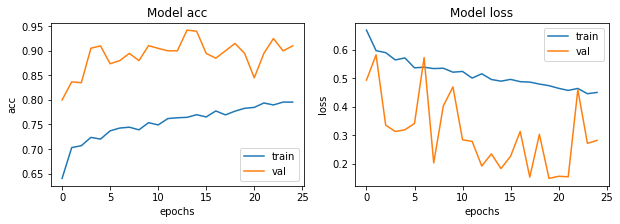

In [11]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

CONFUSION MATRIX


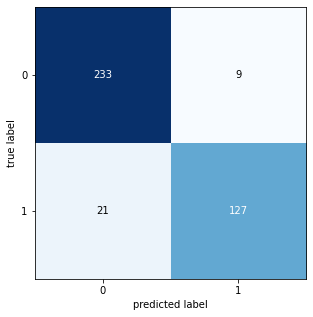


TEST METRICS ----------------------
Accuracy: 92.3076923076923%
Precision: 93.38235294117648%
Recall: 85.8108108108108%
F1-score: 89.43661971830986

TRAIN METRIC ----------------------
Train acc: 79.56


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX')
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()
# print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history2.history['acc'][-1])*100, 2)))

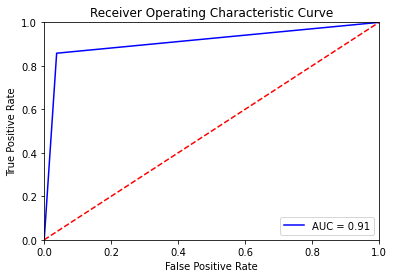

In [13]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test_labels, np.round(preds))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()